In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import requests
%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from cartopy import config
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import shapely.geometry as geometry
from geojson import Polygon
import pymongo

from datetime import datetime
from datetime import timedelta

import pdb
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

In [2]:
arFileName = '/storage/MERRA2.ar_tag.Guan_Waliser_v2.3hourly.1980to2017.nc4'
ds = xr.open_dataset(arFileName, decode_cf=False)

In [24]:
def alpha_shape(points, alpha, idx):
    """
    http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    concave_hull = cascaded_union(triangles)
    if isinstance(concave_hull, geometry.multipolygon.MultiPolygon):
        pdb.set_trace()
        print('shape {} is crossing antimeridian'.format(idx))
    return concave_hull, edge_points

def get_perim_df(df, idx=1, alpha=.5, buffer=None):
    AR = df[ df['shape'] == idx ]
    
    ARRange = AR['lon'].max() - AR['lon'].min()
    if ARRange > 180:
        AR['lon'] = transform_long(AR['lon'].values)
        print('transforming lon points > 60 to negative plane')
        
    
    points = [geometry.Point(xy) for xy in list(zip(AR.lon, AR.lat))]
    concave_hull, edge_points = alpha_shape(points, alpha=alpha, idx=idx)
    if isinstance(concave_hull, geometry.multipolygon.MultiPolygon):
        lat, lon = [], []
        for poly in concave_hull:
            if buffer:
                plon, plat = poly.buffer(buffer).exterior.coords.xy
            else:
                plon, plat = poly.exterior.coords.xy
            #plon = transform_long(plon)
            lat.extend(plat)
            lon.extend(plon)
    else:
        if buffer:
            lon, lat = concave_hull.buffer(buffer).exterior.coords.xy
        else:
            lon, lat = concave_hull.exterior.coords.xy
    pdf = pd.DataFrame({'lon': lon, 'lat': lat, 'shape': idx})
    #pdf = pdf[ np.abs(pdf['lon']) != 180] #remove antimeridian points
    return pdf

def transform_long(plon):
    '''lon > 60 are transformed to negative coords'''
    tlon = []
    for long in plon:
        if long > 60:
            tlon.append( long -  360 )
        else:
            tlon.append(long)
    return tlon

def plot_scatter(df, date):
    fig = plt.figure(figsize=(9,6))
    x = df['lon'].values
    y = df['lat'].values
    z = df['shape'].values
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    ax.scatter(x, y, z)
    return fig

def make_doc(df, date):
    doc = {}
    doc['shapeId'] = shapeId
    outline = tuple(map(tuple, df[['lon', 'lat']].values))
    doc['geoLocation'] = Polygon(outline)
    doc['date'] = date
    docs.append(doc)
    return doc

def make_df(ds, time=0):
    shape = ds.shape.sel(time=time)
    df = shape.to_dataframe()
    df = df.reset_index()
    df.drop(['ens', 'lev', 'time'], axis=1, inplace=True)
    df = df[df['shape'] != -9999]
    
    df['lon'] = df['lon'].round(3)
    return df

def create_collection(dbName='argo', collectionName='arShapes'):
    dbUrl = 'mongodb://localhost:27017/'
    client = pymongo.MongoClient(dbUrl)
    db = client['argo']
    coll = db[collectionName]
    coll = init_profiles_collection(coll)
    return coll    

def init_profiles_collection(coll):
    try:
        coll.create_index([('date', pymongo.DESCENDING)])
        coll.create_index([('shapeId', pymongo.DESCENDING)])
    except:
        logging.warning('not able to get collections or set indexes')
    return coll

In [33]:
da = ds.shape

In [37]:
da

<xarray.DataArray 'shape' (ens: 1, time: 109568, lev: 1, lat: 361, lon: 576)>
[22783131648 values with dtype=int16]
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1e+03
  * time     (time) float64 0.0 3.0 6.0 9.0 ... 3.287e+05 3.287e+05 3.287e+05
  * ens      (ens) float64 1.0
Attributes:
    _FillValue:  -9999
    long_name:   Shape
    units:       none

In [39]:
ds.info()

xarray.Dataset {
dimensions:
	ens = 1 ;
	lat = 361 ;
	lev = 1 ;
	limitID = 5 ;
	lon = 576 ;
	stageID = 9 ;
	time = 109568 ;

variables:
	int16 shape(ens, time, lev, lat, lon) ;
		shape:_FillValue = -9999 ;
		shape:long_name = Shape ;
		shape:units = none ;
	float64 axis(ens, time, lev, lat, lon) ;
		axis:_FillValue = -9999.0 ;
		axis:long_name = Axis ;
		axis:units = none ;
	float64 tnsct(ens, time, lev, lat, lon) ;
		tnsct:_FillValue = -9999.0 ;
		tnsct:long_name = Transect ;
		tnsct:units = none ;
	int16 lfloc(ens, time, lev, lat, lon) ;
		lfloc:_FillValue = -9999 ;
		lfloc:long_name = Landfall Location ;
		lfloc:units = none ;
	int8 ar_binary_tag(time, lat, lon) ;
		ar_binary_tag:long_name = Binary Indicator of Atmospheric River ;
		ar_binary_tag:units = none ;
		ar_binary_tag:description = binary indicator of atmospheric river ;
		ar_binary_tag:scheme = Guan&Waliser ;
		ar_binary_tag:version = 2 ;
	int16 islnd(lat, lon) ;
		islnd:_FillValue = -9999 ;
		islnd:long_name = Is Land (Ma

In [25]:
date = datetime.strptime('2010-01-01 00', '%Y-%m-%d %H')
refDate = datetime.strptime('1980-01-01 00', '%Y-%m-%d %H')
coll = create_collection()
timeDelta = date - refDate
hourDelta = timeDelta.total_seconds() / 60 ** 2
df = make_df(ds, time=hourDelta)
df.head()

,lat,lon,shape
18443,-74.0,-173.125,1
18444,-74.0,-172.500,1
18445,-74.0,-171.875,1
18446,-74.0,-171.250,1
18447,-74.0,-170.625,1


In [26]:
groups = df.groupby(['shape'])
docs = []
for shapeId, sdf in groups:
    doc = {}
    doc['_id'] = str(shapeId) + '_' + str(hourDelta)
    doc['shapeId'] = shapeId
    pdf = get_perim_df(sdf, idx=shapeId)
    outline = tuple(map(tuple, pdf[['lon', 'lat']].values))
    doc['geoLocation'] = Polygon(outline)
    doc['date'] = date
    docs.append(doc)
    

transforming lon points > 60 to negative plane
transforming lon points > 60 to negative plane
transforming lon points > 60 to negative plane


In [27]:
coll.drop()
coll.insert_many(docs)

In [28]:
pdf.lon

0     18.750
1     18.125
2     18.125
3     18.125
4     16.875
5     16.250
6     14.375
7     13.750
8     13.125
9     13.125
10    14.375
11    15.625
12    16.250
13    16.875
14    18.125
15    19.375
16    18.125
17    18.750
18    19.375
19    20.000
20    20.625
21    21.250
22    21.875
23    22.500
24    23.125
25    23.750
26    23.750
27    24.375
28    25.000
29    25.625
30    25.625
31    25.625
32    25.625
33    25.000
34    23.125
35    23.125
36    22.500
37    21.875
38    20.000
39    19.375
40    18.750
Name: lon, dtype: float64

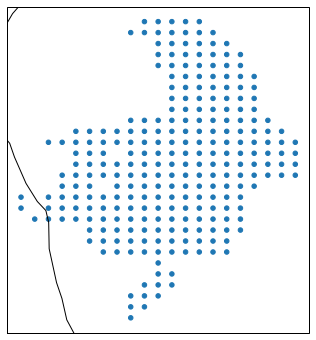

In [29]:
plot1 = plot_scatter(sdf, date)

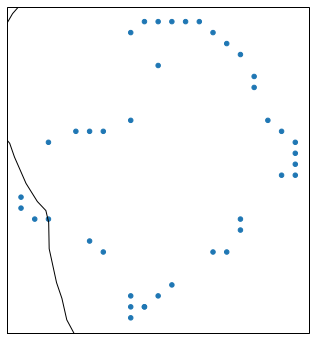

In [30]:
convexShapeScatter = plot_scatter(pdf, date)

transforming lon points > 60 to negative plane


/home/tyler/anaconda3/envs/argo/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


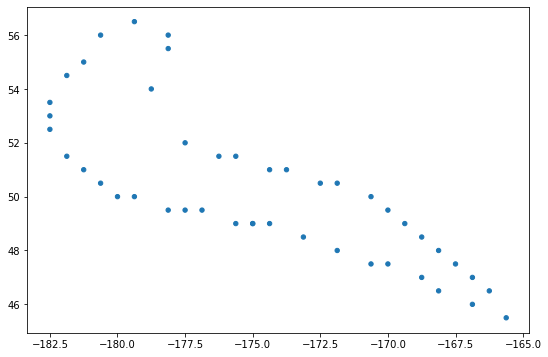

In [32]:
purp = get_perim_df(df, idx=19, buffer=0)

fig = plt.figure(figsize=(9,6))
x = purp['lon'].values
y = purp['lat'].values
z = purp['shape'].values
ax = plt.axes()
ax.scatter(x, y, z)

#purpScat = plot_scatter(purp, '')

In [9]:
purp.lon.tolist()

[35.625,
 35.0,
 34.375,
 33.75,
 33.125,
 30.625,
 30.0,
 29.375,
 28.125,
 27.5,
 26.25,
 25.625,
 25.0,
 24.375,
 23.75,
 21.875,
 20.625,
 16.875,
 16.875,
 16.25,
 15.0,
 14.375,
 13.75,
 13.125,
 12.5,
 11.875,
 11.25,
 10.0,
 9.375,
 8.125,
 7.5,
 6.875,
 5.625,
 5.0,
 3.75,
 2.5,
 1.875,
 2.5,
 3.125,
 4.375,
 5.0,
 6.25,
 5.0,
 4.375,
 3.75,
 3.125,
 1.875,
 1.25,
 0.625,
 -0.0,
 -0.625,
 -1.25,
 -2.5,
 -3.125,
 -3.75,
 -5.0,
 -5.625,
 -6.25,
 -7.5,
 -8.125,
 -9.375,
 -10.0,
 -10.625,
 -11.25,
 -11.875,
 -13.125,
 -13.75,
 -14.375,
 -13.75,
 -12.5,
 -11.875,
 -11.25,
 -10.625,
 -10.0,
 -9.375,
 -8.75,
 -8.125,
 -7.5,
 -6.875,
 -6.25,
 -5.625,
 -5.0,
 -4.375,
 -3.75,
 -2.5,
 -1.25,
 -0.0,
 0.625,
 1.25,
 1.875,
 2.5,
 3.125,
 4.375,
 5.625,
 6.25,
 7.5,
 8.75,
 10.0,
 10.625,
 11.875,
 12.5,
 13.75,
 14.375,
 15.625,
 16.25,
 16.875,
 18.125,
 18.75,
 19.375,
 20.0,
 20.625,
 21.875,
 22.5,
 23.125,
 23.75,
 24.375,
 25.625,
 26.875,
 28.125,
 28.75,
 29.375,
 30.0,
 30.625,
 3

In [12]:
et = df[df['shape'] == 18].lon.round(3)

In [14]:
et.tolist()

[2.5,
 1.875,
 2.5,
 3.125,
 3.75,
 2.5,
 3.125,
 3.75,
 4.375,
 5.0,
 5.625,
 3.125,
 3.75,
 4.375,
 5.0,
 5.625,
 6.25,
 6.875,
 7.5,
 8.125,
 4.375,
 5.0,
 5.625,
 6.25,
 6.875,
 7.5,
 8.125,
 8.75,
 9.375,
 10.0,
 6.25,
 6.875,
 7.5,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 6.875,
 7.5,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 12.5,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 12.5,
 13.125,
 -6.25,
 -5.625,
 -5.0,
 7.5,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 12.5,
 13.125,
 13.75,
 -8.125,
 -7.5,
 -6.875,
 -6.25,
 -5.625,
 -5.0,
 -4.375,
 -3.75,
 -3.125,
 -2.5,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 12.5,
 13.125,
 13.75,
 14.375,
 -10.625,
 -10.0,
 -9.375,
 -8.75,
 -8.125,
 -7.5,
 -6.875,
 -6.25,
 -5.625,
 -5.0,
 -4.375,
 -3.75,
 -3.125,
 -2.5,
 -1.875,
 -1.25,
 -0.625,
 -0.0,
 0.625,
 1.25,
 1.875,
 8.125,
 8.75,
 9.375,
 10.0,
 10.625,
 11.25,
 11.875,
 12.5,
 